In [10]:
#math and linear algebra stuff
import random
import numpy as np
import numpy.linalg as la
import scipy as sc
import scipy.ndimage as scim
import scipy.signal as sisp
from scipy import misc

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (30.0, 30.0)
#mpl.rc('text', usetex = True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

#Image stuff
from skimage import color
from skimage import exposure

# Partial Differential Equations and signal processing

PDEs have been used extensively in signal processing

## Diffusion only system: Heat equations

We recall that heat equations have been first designed to study the physical process of heat diffusion inside a medium, and it is strongly linked with Fourier series expansions. We can notice that trigonometric polynomials of fourier series are eigenfunctions for the laplacian operator.

Let's recall the heat equations:

\begin{align*}
\frac{\partial u}{\partial t} - \alpha \nabla^{2} u = 0
\end{align*}

Where $\alpha$ is a scalar constant called the thermal diffusivity

## Laplacian, gradient and divergence


Where $\nabla : \mathbb{R}^n \mapsto \mathbb{R}^{D \times n}$ is the gradient operator, where D is the spatial dimension of the problem, usually 2 or 3.
In most practical implementation, $\nabla$ is defined using local finite difference, which can be written as a linear operator with a matrix $G$.

In practice people may use Backward difference for the gradient operator with finite difference (Gabriel Peyre  Mathematical Tour's): 
\begin{align*}
  \nabla f[n_1,n_2] &= \begin{pmatrix} \delta_1 f[n_1,n_2] \\ \delta_2 f[n_1,n_2] \end{pmatrix} \\
  &= \begin{pmatrix} f[n_1,n_2]-f[n_1-1,n_2] \\ f[n_1,n_2]-f[n_1,n_2-1] \end{pmatrix}
\end{align*}


Then we have the laplacian, which is defined as $\nabla^{2}=\nabla^T \nabla$ where $\nabla^T$ is the dual operator of gradient called divergence. In practice on can write divergence in the framework of finite difference operator as $G^T$.

By convention, most scientist use Backward difference for the dual version, the divergence operator:
\begin{align*}
  \nabla^T \begin{pmatrix} f_1[n_1,n_2] \\ f_2[n_1,n_2] \end{pmatrix} &= \tilde{\delta_1} f_1[n_1,n_2] + \tilde{\delta_2} f_2[n_1,n_2] \\
  &= f_1[n_1+1,n_2]-f_1[n_1,n_2] + f_2[n_1,n_2+1]-f_2[n_1,n_2]
\end{align*}

In [2]:
G = lambda x : np.dstack(( 
                     np.c_[np.zeros((x.shape[0],1)),np.diff(x,1,1)], # x axis: f[n]-f[n-1] & concat 0 col at left
                     np.r_[np.zeros((1,x.shape[1])),np.diff(x,1,0)])) # y axis: f[n]-f[n-1] & concat 0 row on top

In [3]:
Gt = lambda v : (np.c_[np.diff(v[:,:,0],1,1),np.zeros((v.shape[0],1))] + # x axis: f[n+1]-f[n] & concat 0 col at right
                 np.r_[np.diff(v[:,:,1],1,0),np.zeros((1,v.shape[1]))])# y axis: f[n+1]-f[n] & concat 0 row on bottom

### Heat equation on a 2d discrete function (image)

In the case where we have a 2d discrete function that is an image, here considered as a heat map on a 2d domain, we can arbitrarily set the thermal difusivity $\alpha$ and the time setpping function (time gradient) now reads:

\begin{align*}
  \frac{\partial u}{\partial t} = \alpha \nabla^{2} u
\end{align*}

This time stepping function can easily by applied on a discrete time grid, such that we can take a look at the diffusion of "heat" insite the heat map using

\begin{align*}
  u(t+1) &= u(t) + \frac{\partial u(t)}{\partial t} \\
  &= u(t) + \alpha \nabla^{2} u(t)
\end{align*}

Text(0.5,1,'This is a raccoon')

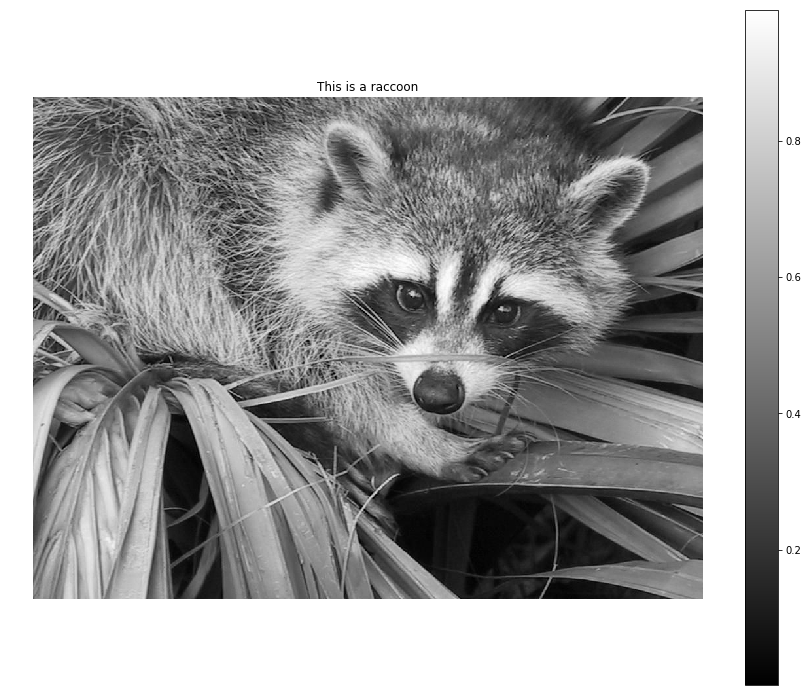

In [4]:
#We first define

uBegin = np.array(color.rgb2gray(misc.face()),np.float32)
plt.figure(figsize=(15,15))
plt.imshow(uBegin, interpolation='nearest', cmap=plt.cm.gray)
plt.axis("off")
# Without specifying vmin and vmax, imshow auto-adjusts its range so that black and white are
# the min and max of the data, respectively, like Matlab's imagesc.
plt.colorbar()       # displays the color bar close to the image
plt.subplots_adjust(top=0.75)
plt.title('This is a raccoon')

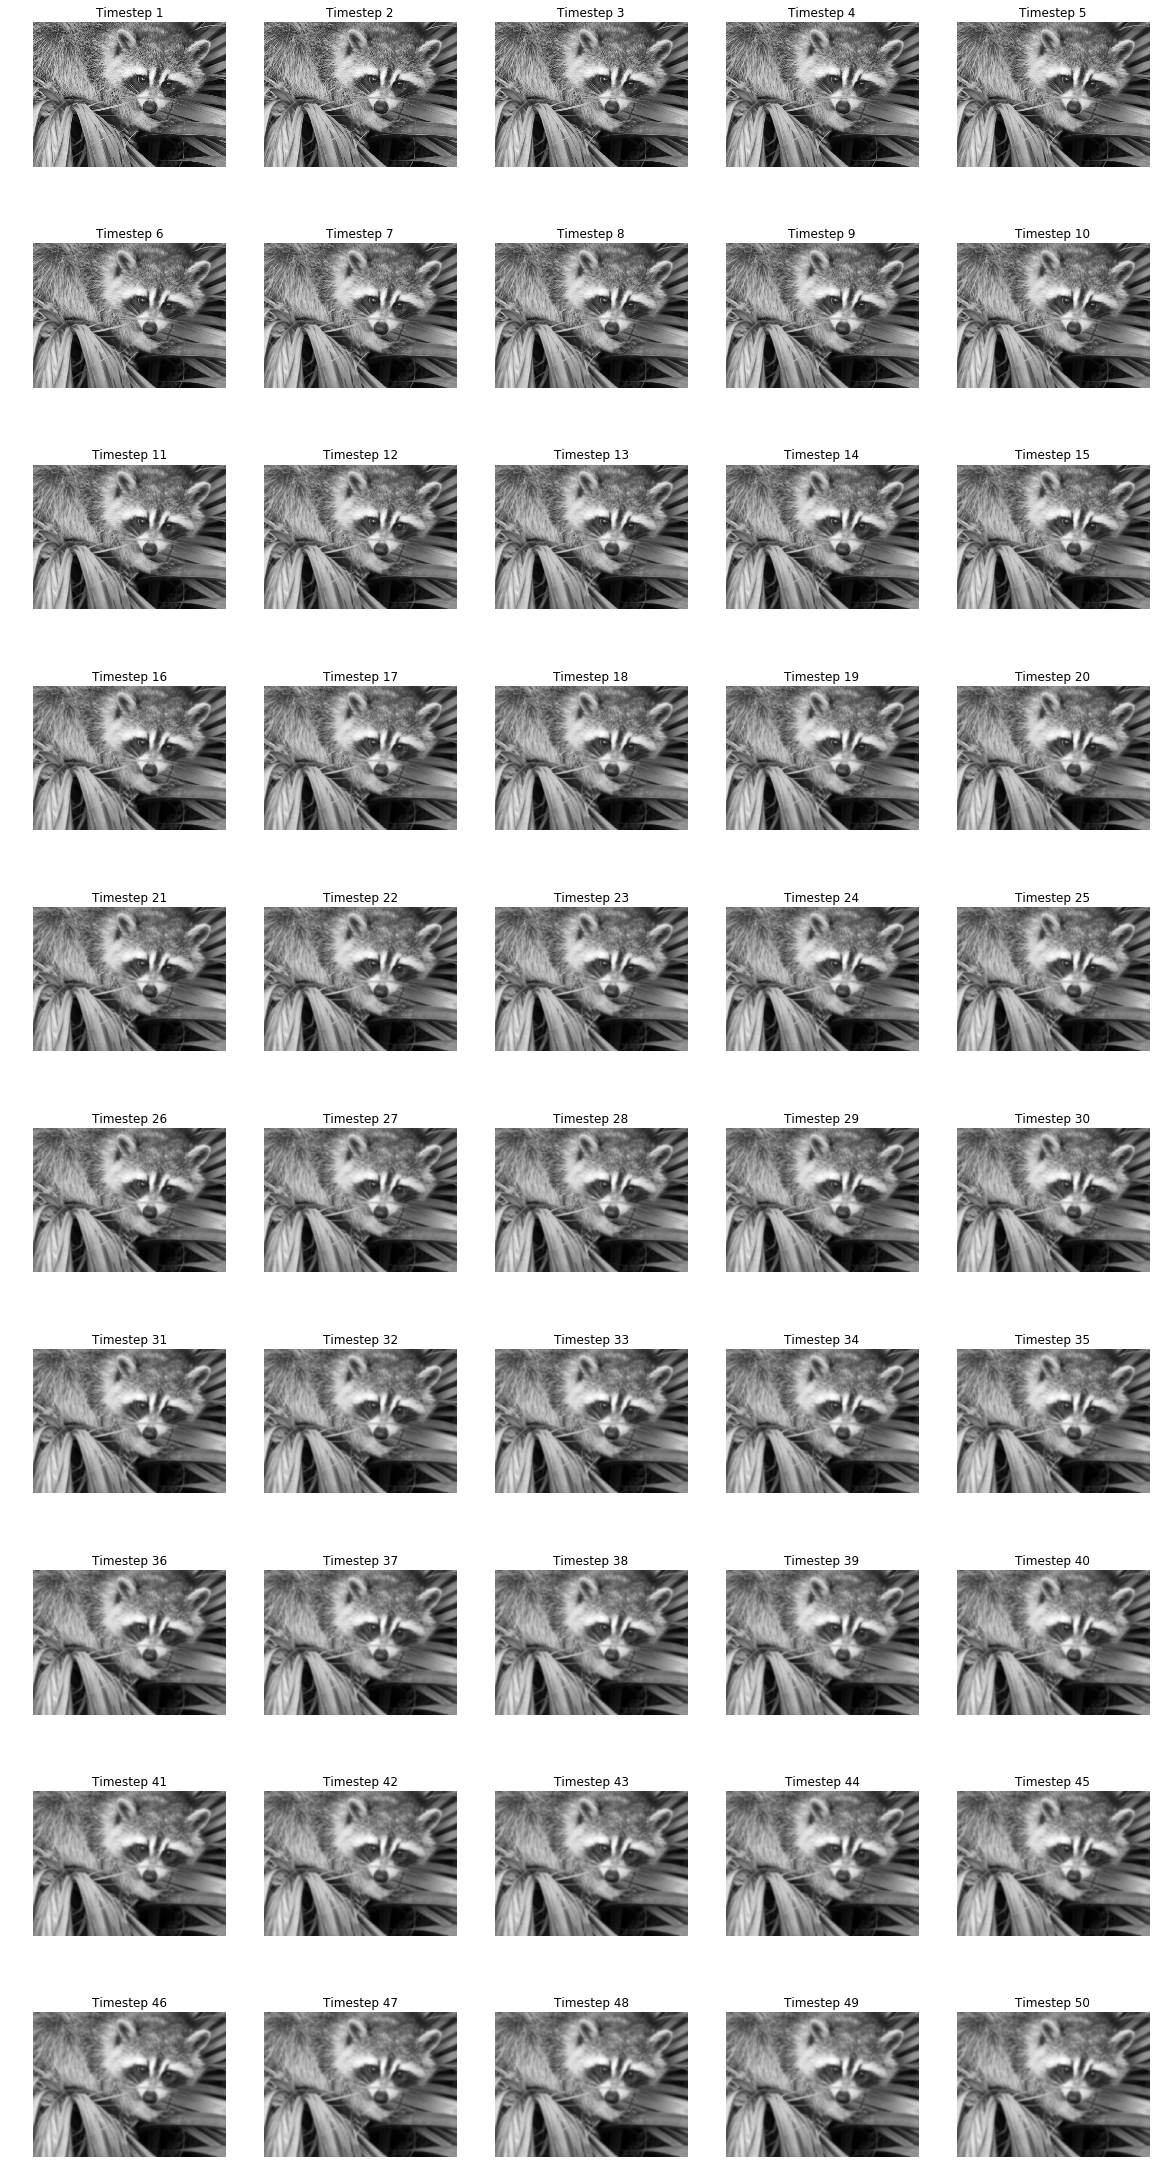

In [5]:
#Now timestepping
nx = 5
ny = 10
alpha=0.2
nSteps = nx*ny
plt.figure(figsize=(4*nx,4*ny))
uCur=uBegin
for i in range(1,nSteps+1):
  uCur=uCur+alpha*Gt(G(uCur))
  ax = plt.subplot(ny,nx,i)
  ax.set_title("Timestep "+str(i))
  plt.imshow(uCur, interpolation='nearest', cmap=plt.cm.gray)
  plt.axis("off")

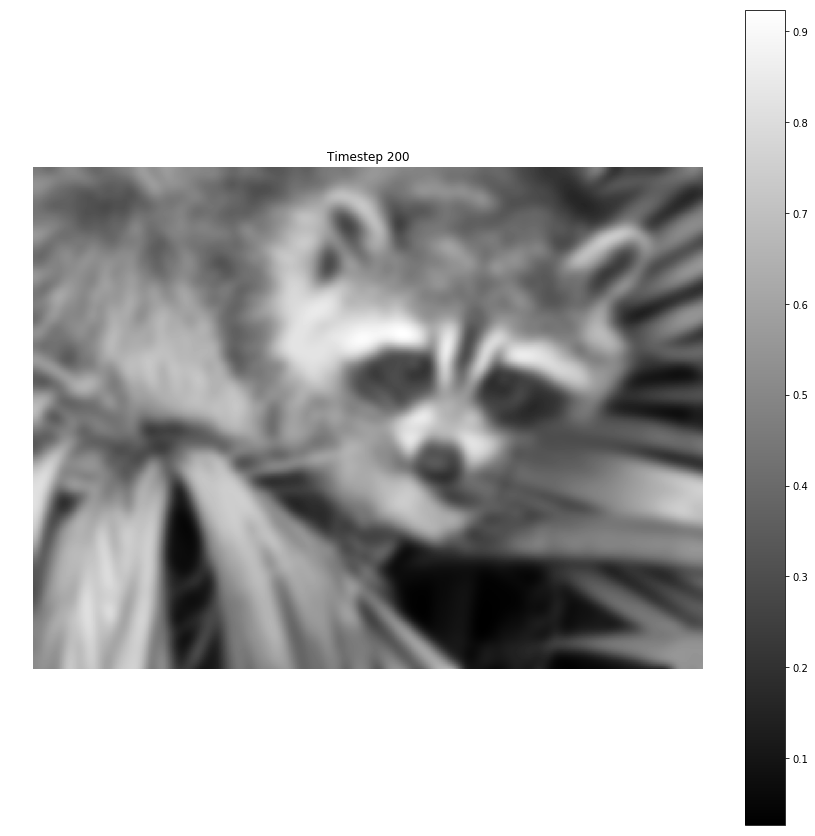

In [6]:
#And then show off result with a lot of iterations
maxSteps = 200
while i < maxSteps:
  uCur=uCur+alpha*Gt(G(uCur))
  i=i+1

plt.figure(figsize=(15,15))
ax = plt.subplot()
ax.set_title("Timestep "+str(i))
plt.imshow(uCur, interpolation='nearest', cmap=plt.cm.gray)
plt.axis("off")
plt.colorbar()

## Anisotropic diffusion

An interesting version of diffusion arise when diffusion itself is signal-dependent.

\begin{align*}
  \frac{\partial u}{\partial t} = \nabla c \cdot \nabla u + c \nabla^{2} u
\end{align*}

Here, $C$ is the thermal diffusity, and is actually a vector valued function / diagonal matrix that depends on the heatmap itself:

\begin{align*}
  c(x,y,t) = \frac{1}{1+\|\nabla u\|}
\end{align*}

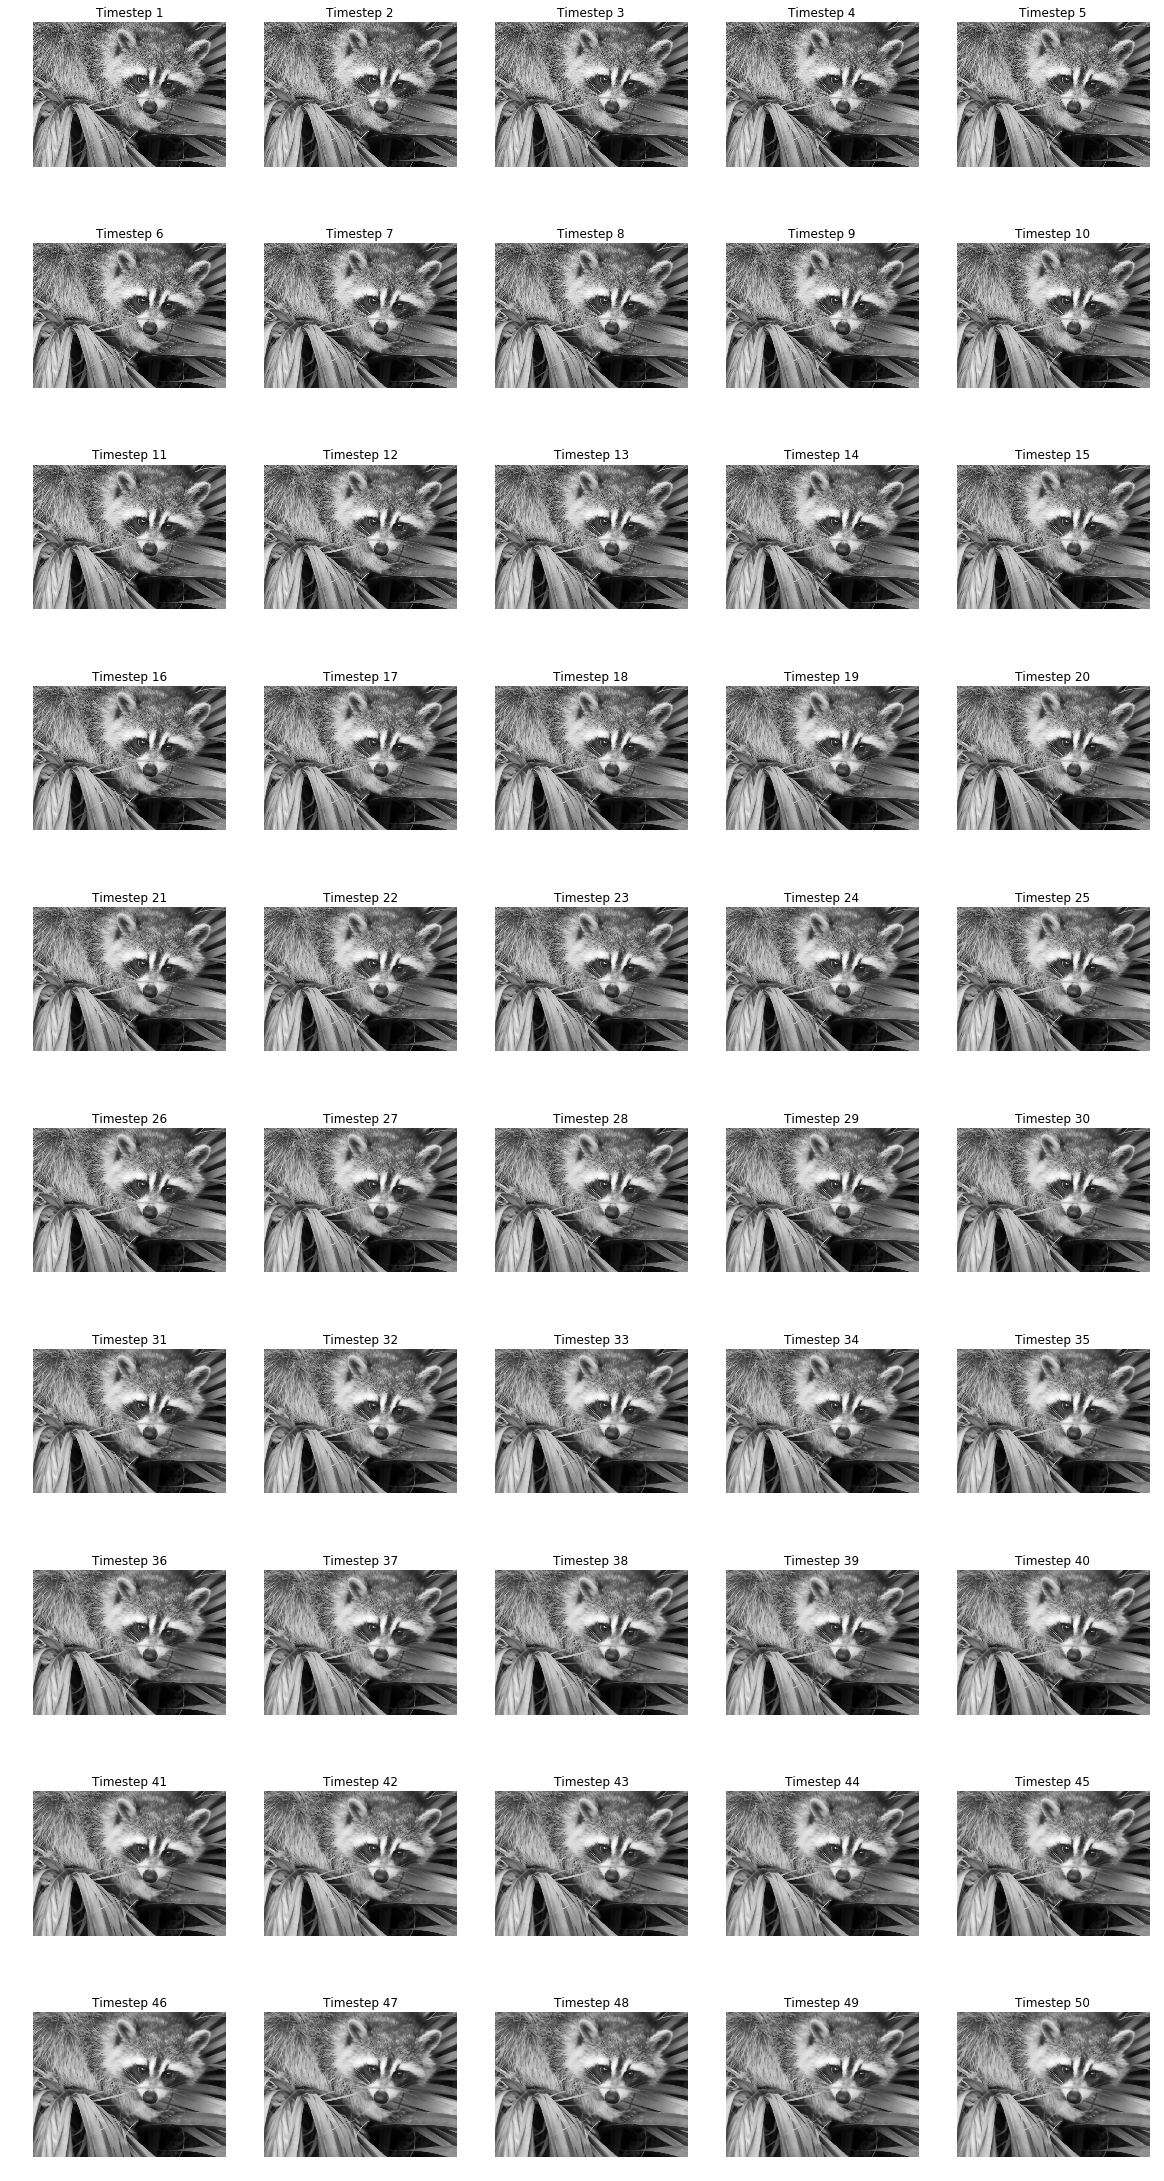

In [7]:
#let's take a look at this anisotropic diffusion on the racoon image
nx = 5
ny = 10
alpha=0.2
nSteps = nx*ny
plt.figure(figsize=(4*nx,4*ny))
uCur=uBegin*100 #One should have a proper dynamic or multiply grad(u) by large factor in c
for i in range(1,nSteps+1):
  grad=G(uCur)
  cCur=1/(1+np.linalg.norm(grad,2,2))
  uCur=uCur+alpha*(np.sum(G(cCur)*grad,2)+cCur*Gt(grad))
  ax = plt.subplot(ny,nx,i)
  ax.set_title("Timestep "+str(i))
  plt.imshow(uCur, interpolation='nearest', cmap=plt.cm.gray)
  plt.axis("off")

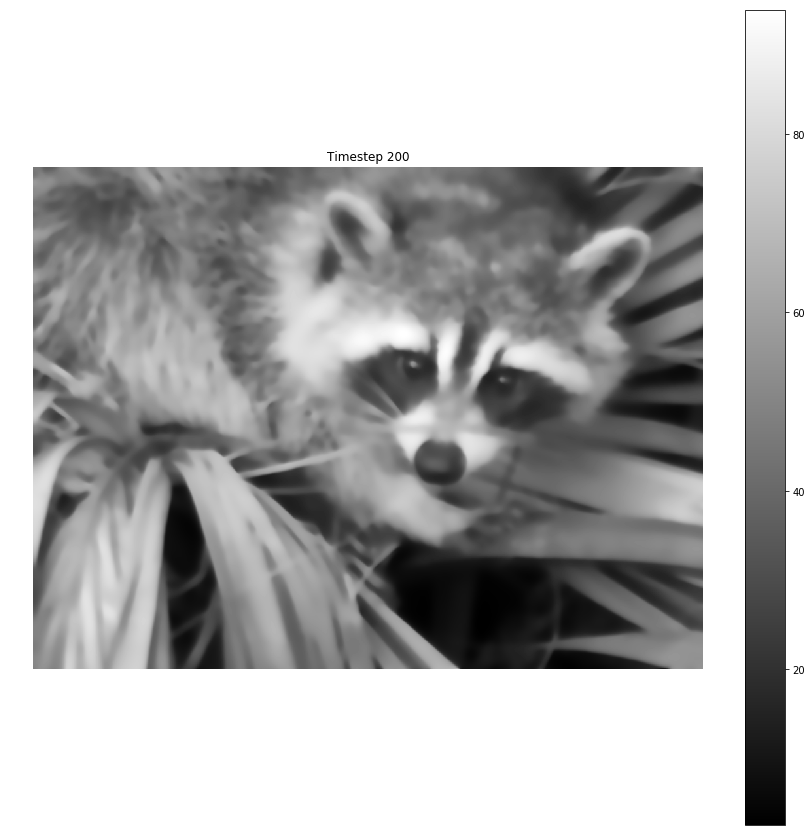

In [8]:
#And then show off result with a lot of iterations
maxSteps = 200
while i < maxSteps:
  grad=G(uCur)
  cCur=1/(1+np.linalg.norm(grad,2,2))
  uCur=uCur+alpha*(np.sum(G(cCur)*grad,2)+cCur*Gt(grad))
  i=i+1

plt.figure(figsize=(15,15))
ax = plt.subplot()
ax.set_title("Timestep "+str(i))
plt.imshow(uCur, interpolation='nearest', cmap=plt.cm.gray)
plt.axis("off")
plt.colorbar()

## Generalization of diffusion systems using Reaction–diffusion systems

### One component reaction-diffusion system

Reaction-diffusion systems is a generalization of diffusion schemes, where the variation of the quantity of interest along time in not only explained by diffusion in a medium, but also by a "reaction".
In general, it helps to model physical systems, like chemical reaction using a specific kind of PDEs of the form:

\begin{align*}
\frac{\partial u}{\partial t} = R(u) + D \nabla^{2} u
\end{align*}

With $D$ a diagonal matrix of diffusion coefficients.


## Gray-Scott diffusion model for two-components chemical reactions

The PDE underlying Gray-Scott has been designed to model a reaction-diffusion system between two compound, $u$ and $v$ that may react together. Let's take an example of such reaction:

\begin{align*}
  U + 2V &\rightarrow 3V \\
  V &\rightarrow P
\end{align*}

Where $P$ is an inert chemical species.
Especially, the equations that describe the source of increase and decrease of each chemical species reads:

\begin{align*}
  \frac{\partial u}{\partial t} = F (1-u) - uv^2 + D_u \nabla^{2} u \\
  \frac{\partial v}{\partial t} = -(F+k)v + uv^2 + D_v \nabla^{2} v \\
\end{align*}

Where we have :
  * $D_u \nabla^{2} u$ is a diffusion term and $D_u$ stands for the diffusivity of species $u$ in the medium
  * $D_v \nabla^{2} v$ is also a diffusion term and $D_v$ stands for the diffusivity of species $v$ in the medium
  * the term $-uv^2$ stands for the reaction rate that makes u to disappear. According to our model, the reaction ($U + 2V \rightarrow 3V$) takes place at a rate proportional to concentration of species u times the square of concentration of species V
  * the term $+uv^2$ stands for the same reaction, but considered from the point of view of $v$ that is created by this reaction
  * the term $F (1-u)$ is the replenishment term. It stands for the rate at which the reaction will be fed with new content of $u$ whenever its concentration deviates from 1. In the physical model F often stands for a membrane that separates reaction medium with another medium that has concentration of chemical $u$ equal to 1.
  * the term $-(F+k) v$ is the diminishment term. It either stands for the diminishment of concentration of chemical $v$, that goes through the membrane whose permeability for v chemical is expressed as (F+k), or stands as the rate where the reaction rate at which the chemical V turns into P.

(-0.5, 255.5, 255.5, -0.5)

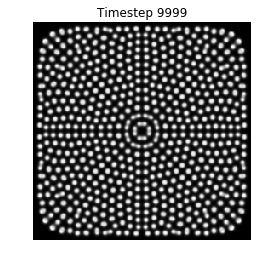

In [16]:
#let's take a look at this reaction diffusion on the racoon image

#Reaction/Diffusion parameters
params = []
params.append((0.16, 0.08, 0.035, 0.065)) # Bacteria 1
params.append((0.14, 0.06, 0.035, 0.065)) # Bacteria 2
params.append((0.16, 0.08, 0.060, 0.062)) # Coral
params.append((0.19, 0.05, 0.060, 0.062)) # Fingerprint
params.append((0.10, 0.10, 0.018, 0.050)) # Spirals
params.append((0.12, 0.08, 0.020, 0.050)) # Spirals Dense
params.append((0.10, 0.16, 0.020, 0.050)) # Spirals Fast
params.append((0.16, 0.08, 0.020, 0.055)) # Unstable
params.append((0.16, 0.08, 0.050, 0.065)) # Worms 1
params.append((0.16, 0.08, 0.054, 0.063)) # Worms 2
params.append((0.16, 0.08, 0.035, 0.060)) # Zebrafish
(Du, Dv, F, k) = random.choice(params)

# Other parameters
nx=256
ny=256
steps = 10000
stepsize=1

#Initialization strategy
U,V = np.zeros((ny+2,nx+2)), np.zeros((ny+2,nx+2))
u,v = U[1:-1,1:-1], V[1:-1,1:-1]
r = 20
u[:] = 1.0
u[ny//2-r:ny//2+r,nx//2-r:nx//2+r] = 0.50
v[ny//2-r:ny//2+r,nx//2-r:nx//2+r] = 0.25

#Run simulation
for i in np.arange(steps):
    Lu = (                 U[0:-2,1:-1] +
          U[1:-1,0:-2] - 4*U[1:-1,1:-1] + U[1:-1,2:] +
                           U[2:  ,1:-1] )
    Lv = (                 V[0:-2,1:-1] +
          V[1:-1,0:-2] - 4*V[1:-1,1:-1] + V[1:-1,2:] +
                           V[2:  ,1:-1] )
    uvv = u*v*v
    u += stepsize*(Du*Lu - uvv +  F   *(1-u))
    v += stepsize*(Dv*Lv + uvv - (F+k)*v    )
    
ax = plt.subplot(1,1,1)
ax.set_title("Timestep "+str(i))
plt.imshow(v, interpolation='nearest', cmap=plt.cm.gray)
plt.axis("off")